# Features Summary of Water Quality Data

This dataset contains water quality measurements from various sites, with the following key features:

- **Site_Id**: Identifier for the site where the data was collected (String).
- **Unit_Id**: Identifier for the unit, mostly missing values.
- **Read_Date**: Date of the reading, indicating the time of data collection.
- **Salinity (ppt)**: Salinity levels in parts per thousand (ppt).
- **Dissolved Oxygen (mg/L)**: Concentration of dissolved oxygen in milligrams per liter.
- **pH (standard units)**: pH level of the water, measured in standard units.
- **Secchi Depth (m)**: Measurement of water transparency or clarity, in meters.
- **Water Depth (m)**: Depth of water at the site, in meters.
- **Water Temp (°C)**: Water temperature in degrees Celsius.
- **Air Temp-Celsius**: Air temperature in Celsius (has few records).
- **Air Temp (°F)**: Air temperature in Fahrenheit, more complete than the Celsius version.
- **Time (24:00)**: Time of the reading in 24-hour format.
- **Field_Tech**: Name or identifier of the field technician who took the measurement.
- **DateVerified**: Date the data was verified.
- **WhoVerified**: Name or identifier of the person who verified the data.
- **AirTemp (C)**: Air temperature in Celsius, complete and consistent with the dataset.
- **Year**: Year of data collection.

## Preprocessing and visualizations

In [64]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns

In [65]:
file_path = os.path.join('..', 'data', 'BKB_WaterQualityData_2020084.csv')
df = pd.read_csv(file_path, index_col=False)

In [66]:
df.head()

,Site_Id,Unit_Id,Read_Date,Salinity (ppt),Dissolved Oxygen (mg/L),pH (standard units),Secchi Depth (m),Water Depth (m),Water Temp (?C),Air Temp-Celsius,Air Temp (?F),Time (24:00),Field_Tech,DateVerified,WhoVerified,AirTemp (C),Year
0,Bay,NaN,1/3/1994,1.3,11.7,7.3,0.40,0.40,5.9,8.0,46.40,11:00,NaN,NaN,NaN,8.0,1994
1,Bay,NaN,1/31/1994,1.5,12.0,7.4,0.20,0.35,3.0,2.6,36.68,11:30,NaN,NaN,NaN,2.6,1994
2,Bay,NaN,2/7/1994,1.0,10.5,7.2,0.25,0.60,5.9,7.6,45.68,9:45,NaN,NaN,NaN,7.6,1994
3,Bay,NaN,2/23/1994,1.0,10.1,7.4,0.35,0.50,10.0,2.7,36.86,NaN,NaN,NaN,NaN,2.7,1994
4,Bay,NaN,2/28/1994,1.0,12.6,7.2,0.20,0.40,1.6,0.0,32.00,10:30,NaN,NaN,NaN,0.0,1994


In [67]:
df['Read_Date'] = pd.to_datetime(df['Read_Date'])
df = df.set_index('Read_Date')
df['Year'] = df['Year'].astype(int)

In [68]:
df.columns

Index(['Site_Id', 'Unit_Id', 'Salinity (ppt)', 'Dissolved Oxygen (mg/L)',
       'pH (standard units)', 'Secchi Depth (m)', 'Water Depth (m)',
       'Water Temp (?C)', 'Air Temp-Celsius', 'Air Temp (?F)', 'Time (24:00)',
       'Field_Tech', 'DateVerified', 'WhoVerified', 'AirTemp (C)', 'Year'],
      dtype='object')

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2371 entries, 1994-01-03 to 2018-12-11
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Site_Id                  2370 non-null   object 
 1   Unit_Id                  32 non-null     object 
 2   Salinity (ppt)           2241 non-null   float64
 3   Dissolved Oxygen (mg/L)  1520 non-null   float64
 4   pH (standard units)      2276 non-null   float64
 5   Secchi Depth (m)         2298 non-null   float64
 6   Water Depth (m)          2300 non-null   float64
 7   Water Temp (?C)          2250 non-null   float64
 8   Air Temp-Celsius         85 non-null     float64
 9   Air Temp (?F)            2300 non-null   float64
 10  Time (24:00)             2308 non-null   object 
 11  Field_Tech               2332 non-null   object 
 12  DateVerified             453 non-null    object 
 13  WhoVerified              453 non-null    object 
 14  AirTem

In [70]:
df.isnull().sum()

Site_Id                       1
Unit_Id                    2339
Salinity (ppt)              130
Dissolved Oxygen (mg/L)     851
pH (standard units)          95
Secchi Depth (m)             73
Water Depth (m)              71
Water Temp (?C)             121
Air Temp-Celsius           2286
Air Temp (?F)                71
Time (24:00)                 63
Field_Tech                   39
DateVerified               1918
WhoVerified                1918
AirTemp (C)                   0
Year                          0
dtype: int64

1. **Data Cleaning and Feature Selection**

To prepare the data for anomaly detection, we removed columns with a high proportion of missing values and those not relevant to our analysis. Specifically, we dropped the following columns:

- `Site_Id`, `Unit_Id`, `Air Temp-Celsius`, `Field_Tech`, `DateVerified`, and `WhoVerified`

These columns had limited information or non-numeric data that doesn’t support anomaly detection.

In [71]:
df = df.drop(columns=['Site_Id', 'Unit_Id','Air Temp-Celsius', 'Field_Tech', 'DateVerified', 'WhoVerified', 'Year']) 

For the remaining columns, we will fill missing values using the mean of each feature to ensure a complete dataset.

In [72]:
df.columns

Index(['Salinity (ppt)', 'Dissolved Oxygen (mg/L)', 'pH (standard units)',
       'Secchi Depth (m)', 'Water Depth (m)', 'Water Temp (?C)',
       'Air Temp (?F)', 'Time (24:00)', 'AirTemp (C)'],
      dtype='object')

In [73]:
df['Salinity (ppt)'] = df['Salinity (ppt)'].fillna(df['Salinity (ppt)'].mean())
df['Dissolved Oxygen (mg/L)'] = df['Dissolved Oxygen (mg/L)'].fillna(df['Dissolved Oxygen (mg/L)'].mean())
df['pH (standard units)'] = df['pH (standard units)'].fillna(df['pH (standard units)'].mean())
df['Secchi Depth (m)'] = df['Secchi Depth (m)'].fillna(df['Secchi Depth (m)'].mean())
df['Water Depth (m)'] = df['Water Depth (m)'].fillna(df['Water Depth (m)'].mean())
df['Water Temp (?C)'] = df['Water Temp (?C)'].fillna(df['Water Temp (?C)'].mean())
df['Air Temp (?F)'] = df['Air Temp (?F)'].fillna(df['Air Temp (?F)'].mean())

In [74]:
df = df.select_dtypes(include=['number'])

In [75]:
df_resampled = df.resample('W').mean()  #  resample the data to a weekly frequency, calculating the mean for each week
df = df_resampled.interpolate(method='time')

In [76]:
df.head()

,Salinity (ppt),Dissolved Oxygen (mg/L),pH (standard units),Secchi Depth (m),Water Depth (m),Water Temp (?C),Air Temp (?F),AirTemp (C)
Read_Date,,,,,,,,
1989-05-14,0.717068,6.646263,7.500000,0.300000,0.9,17.0,62.051637,-17.777778
1989-05-21,0.717068,12.000000,7.500000,0.200000,0.6,17.5,68.900000,20.500000
1989-05-28,0.717068,6.646263,8.000000,0.400000,0.8,23.0,77.000000,25.000000
1989-06-04,0.717068,12.000000,8.000000,0.400000,0.9,25.5,84.200000,29.000000
1989-06-11,0.717068,11.107711,8.083333,0.383333,0.9,26.0,83.900000,28.833333


### Feature selection

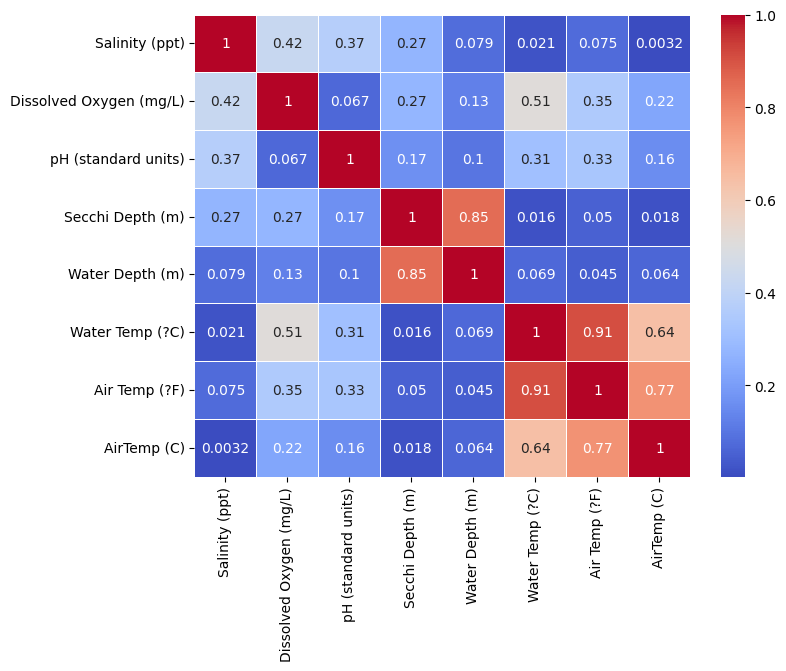

In [77]:
plt.figure(figsize=(8, 6))
corr_matrix = df.corr().abs()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

In [78]:
def correlation(df, threshold):
    '''
    Th
    '''
    col_corr = set()  # Set of all the names of correlated columns
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [79]:
corr_features = correlation(df, 0.8)
len(set(corr_features))

2

In [80]:
select_df = df.drop(corr_features, axis=1)

In [81]:
select_df.head()

,Salinity (ppt),Dissolved Oxygen (mg/L),pH (standard units),Secchi Depth (m),Water Temp (?C),AirTemp (C)
Read_Date,,,,,,
1989-05-14,0.717068,6.646263,7.500000,0.300000,17.0,-17.777778
1989-05-21,0.717068,12.000000,7.500000,0.200000,17.5,20.500000
1989-05-28,0.717068,6.646263,8.000000,0.400000,23.0,25.000000
1989-06-04,0.717068,12.000000,8.000000,0.400000,25.5,29.000000
1989-06-11,0.717068,11.107711,8.083333,0.383333,26.0,28.833333


In [82]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot
from bokeh.palettes import Set1_6

output_notebook()


plots = []
colors = Set1_6
for i, column in enumerate(select_df.columns):

    p = figure(x_axis_type="datetime", title=column, width=500, height=200)
    color = colors[i % len(colors)]
    p.line(select_df.index, select_df[column], line_width=2, color=color)

    plots.append(p)

grid = gridplot(plots, ncols=2)

show(grid)

Loading BokehJS ...

In [83]:
select_df.columns

Index(['Salinity (ppt)', 'Dissolved Oxygen (mg/L)', 'pH (standard units)',
       'Secchi Depth (m)', 'Water Temp (?C)', 'AirTemp (C)'],
      dtype='object')

In [84]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit and transform the selected columns
select_df[select_df.columns] = scaler.fit_transform(select_df[select_df.columns])

# Display the standardized data
select_df.head()

,Salinity (ppt),Dissolved Oxygen (mg/L),pH (standard units),Secchi Depth (m),Water Temp (?C),AirTemp (C)
Read_Date,,,,,,
1989-05-14,-0.222081,-0.293043,0.429936,-0.613595,-0.101129,-3.122130
1989-05-21,-0.222081,2.273111,0.429936,-0.952922,-0.034617,0.532294
1989-05-28,-0.222081,-0.293043,1.249761,-0.274268,0.697018,0.961915
1989-06-04,-0.222081,2.273111,1.249761,-0.274268,1.029580,1.343799
1989-06-11,-0.222081,1.845418,1.386399,-0.330823,1.096092,1.327887


### Boxplots

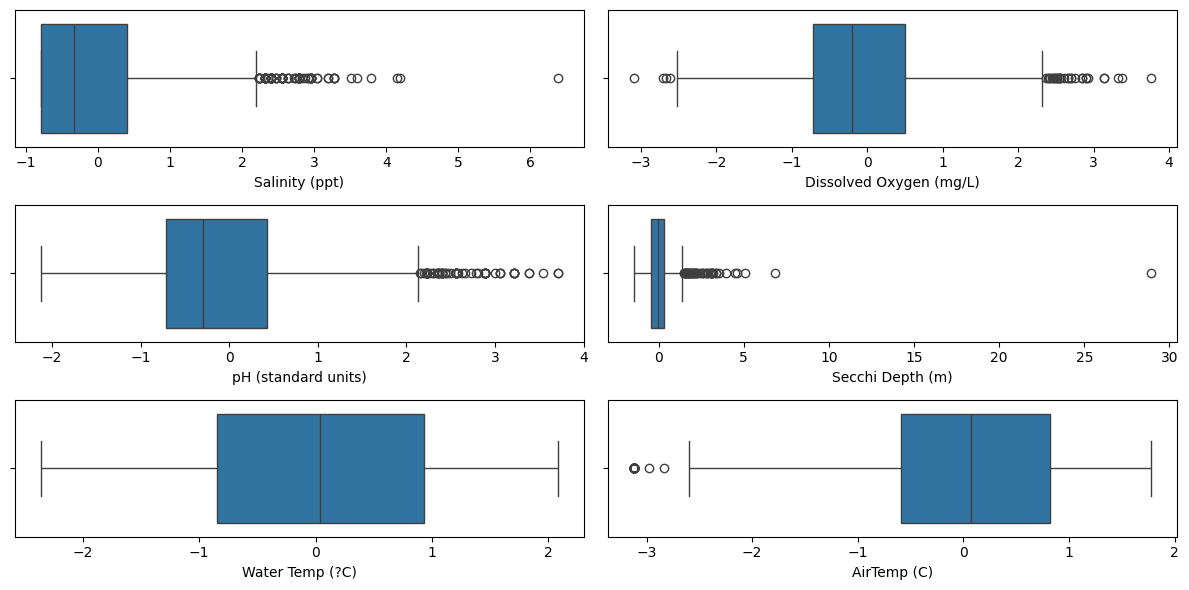

In [95]:
f, ax= plt.subplots(3,2 , figsize=(12,6))
ax = ax.flatten()

for index, cols in enumerate(select_df.columns):
    sns.boxplot(data = select_df, x = cols , ax = ax[index])
    
plt.tight_layout()
plt.show()

## Isolation Forest

In [61]:
model = IsolationForest(contamination=0.04, random_state=42)
select_df['anomaly'] = model.fit_predict(select_df)

select_df['anomaly'] = select_df['anomaly'] == -1

In [62]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go

# Initialize a subplot layout with one row and one column
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

# Loop over each selected column and add it to the plot
for column in select_df.columns[:-1]:  # Exclude the 'anomaly' column
    # Add the time series line plot for the column
    fig.add_trace(
        go.Scatter(x=select_df.index, y=select_df[column], mode='lines', name=column),
        row=1, col=1
    )

# Filter out the rows where anomalies are detected
anomalies = select_df[select_df['anomaly']]

# Loop through each column again to add anomaly markers
for column in select_df.columns[:-1]:  # Exclude the 'anomaly' column
    fig.add_trace(
        go.Scatter(
            x=anomalies.index,
            y=anomalies[column],
            mode='markers',
            name=f'Anomaly {column}',
            marker=dict(color='red', size=7)
        ),
        row=1, col=1
    )

# Update layout to add titles and set figure dimensions
fig.update_layout(
    height=500, 
    width=1000, 
    title="Time Series Data with Combined Anomaly Detection",
    xaxis_title="Timestamps",
    yaxis_title="Values"
)

# Show the figure
fig.show()

In [20]:
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

fig.add_trace(
    go.Scatter(x=select_df.index, y=select_df['p (mbar)'], mode='lines', name='p (mbar)'),
    row=1, col=1
)

# Plot the anomalies as red markers on the same plot
anomalies = select_df[select_df['anomaly_p']]
fig.add_trace(
    go.Scatter(
        x=anomalies.index,
        y=anomalies['p (mbar)'],
        mode='markers',
        name='Anomaly p (mbar)',
        marker=dict(color='red', size=7)
    ),
    row=1, col=1
)

fig.update_layout(height=400, width=900, title="Weather Data with Anomaly Detection", xaxis_title="Timestamps", yaxis_title="p (mbar)")
fig.show()

In [35]:
data = pd.read_csv(os.path.join('..', 'data', 'Fraudulent_E-Commerce_Transaction_Data.csv'))

In [37]:
data.columns

Index(['Transaction ID', 'Customer ID', 'Transaction Amount',
       'Transaction Date', 'Payment Method', 'Product Category', 'Quantity',
       'Customer Age', 'Customer Location', 'Device Used', 'IP Address',
       'Shipping Address', 'Billing Address', 'Is Fraudulent',
       'Account Age Days', 'Transaction Hour'],
      dtype='object')

In [ ]:
px.line(data, x = data.index ,y= data['Transaction Amount'])